# Landmark Classification with Vision Transformers

This notebook attempts to classify landmarks. A [subset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip) of the [google landmark dataset](https://github.com/cvdfoundation/google-landmark) is used. It contains images of 50 different landmarks. 

The notebook uses pretrained vision transformer networks via the pytorch implementation from [here](https://github.com/lukemelas/PyTorch-Pretrained-ViT). Only the final classifier is replaced and retrained. A quick overview of ViTs and the model used can be found in [this blog post](https://sh-tsang.medium.com/review-vision-transformer-vit-406568603de0). The fine tuning follows the advise from [arXiv:2106.10270](https://arxiv.org/abs/2106.10270). Some useful advice is also taken from [here](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055).

In [1]:
## imports

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Subset

from pytorch_pretrained_vit import ViT

from PIL import Image

%matplotlib inline

In [2]:
# use cuda if available
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


---
## Preprocessing

Values for RGB normalisation are due to PyTorches internals. From [this blog post](https://sparrow.dev/pytorch-normalize/):

> That’s because torchvision splits the work up between ToTensor() and Normalize():
>    - ToTensor() takes a PIL image (or np.int8 NumPy array) with shape (n_rows, n_cols, n_channels) as input and returns a PyTorch tensor with floats between 0 and 1 and shape (n_channels, n_rows, n_cols).
>    - Normalize() subtracts the mean and divides by the standard deviation of the floating point values in the range [0, 1].
> 
> That means you need to know the mean and standard deviation of the floats, not the original pixels.

In [3]:
## define data loader
def get_dataloaders(batch_size, img_size, data_dir):

    # define directories
    train_dir = data_dir + '/train/'
    test_dir = data_dir + '/test/'

    # define number of workers
    num_workers = 1
    
    # split between train and val
    val_size = 0.2
    
    # define transforms for test and training data
    transform_test = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(180),
        transform_test
    ])

    # define datasets
    test_dataset = datasets.ImageFolder(test_dir, transform_test)
    eval_dataset = datasets.ImageFolder(train_dir, transform_test)
    train_dataset = datasets.ImageFolder(train_dir, transform_train)
    
    # get indices for dataset split
    length = len(train_dataset)
    indices = list(range(length))
    np.random.shuffle(indices)
    split = int(np.floor(val_size * length))
    train_idx, eval_idx = indices[split:], indices[:split]
    
    # obtain split datasets
    eval_dataset = Subset(eval_dataset, eval_idx)
    train_dataset  = Subset(train_dataset, train_idx)
    
    # prepare data loaders
    loaders = {}
    loaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                    num_workers=num_workers, shuffle=True)
    loaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                    num_workers=num_workers, shuffle=True)
    loaders['eval'] = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, 
                                num_workers=num_workers, shuffle=True)

    return loaders

In [4]:
## define loader
batch_size = 64
img_size = 224
data_dir = './data/landmark_images/'

# create dataloader
loaders = get_dataloaders(batch_size, img_size, data_dir)

# print info
print('Number of training images: ', len(loaders['train'].dataset)) 
print('Number of validation images: ', len(loaders['eval'].dataset)) 
print('Number of test images: ', len(loaders['test'].dataset))
print('Number of classes: ', len(loaders['test'].dataset.classes))

Number of training images:  3997
Number of validation images:  999
Number of test images:  1250
Number of classes:  50


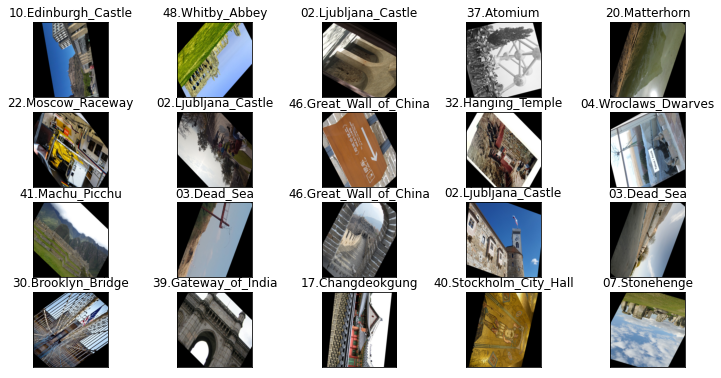

In [5]:
## show some example images
dataiter = iter(loaders['train'])
images, labels = dataiter.next()

MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

# get list of class
classes = loaders['test'].dataset.classes

fig = plt.figure(figsize=(2.5*5, 2*4))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    images[idx] = images[idx] * STD[:, None, None] + MEAN[:, None, None]
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

In [6]:
## Specify architecture

# get vit model, pretrained on ImageNet-21k (224x224 px)
model = ViT('B_16', pretrained=True)

# fix all params in place, except the final layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# add new final layer to match data set
final_layer = nn.Linear(model.fc.in_features, 50)
model.fc = final_layer

# init new final layer
for layer in model.fc.modules():
    torch.nn.init.xavier_normal_(layer.weight)
    torch.nn.init.constant_(layer.bias, 0)

# move to gpu if available
if use_cuda:
    model = model.cuda()

Loaded pretrained weights.


---
## Losses and Optimisers

In [arXiv:2106.10270](https://arxiv.org/abs/2106.10270), SGD with momentum and weight decay is recommended. However, I have found ADAM without weight decay to work significantly better for me.

In [7]:
# cross-entropy loss
criterion = nn.CrossEntropyLoss()

# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

---
## Training

In [8]:
## define the training process
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    # initialize tracker for minimum validation loss
    eval_loss_min = np.Inf 
    
    # initialize tracker for mean validation loss
    eval_loss_ma = []
    
    # initialize learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    # get start time
    start_time = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        eval_loss = 0.0
        
        # train mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass and backprop
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # update average train loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))

        # eval mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['eval']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass
            output = model(data)
            loss = criterion(output, target)

            # update average validation loss
            eval_loss = eval_loss + ((1 / (batch_idx + 1)) * (loss.item() - eval_loss))
        
        # adapt learning rate 
        scheduler.step()
            
        # print some statistics 
        print('Epoch [{:3d}/{:3d}] | Time: {:5.1f} min | Training Loss: {:6.4f} | Validation Loss: {:6.4f}'.format(
                        epoch, n_epochs, (time.time() - start_time)/60., train_loss, eval_loss))

        # save the best model every 5 epochs
        if eval_loss < eval_loss_min:
            torch.save(model.state_dict(), save_path)
            eval_loss_min = eval_loss
        
    return model

In [9]:
## run the training
num_epochs = 50

# train
model = train(num_epochs, loaders, model, optimizer, criterion, use_cuda, 'model_transfer.pt')

Epoch [  1/ 50] | Time:   0.8 min | Training Loss: 2.5130 | Validation Loss: 1.4751
Epoch [  2/ 50] | Time:   1.6 min | Training Loss: 1.5303 | Validation Loss: 1.2554
Epoch [  3/ 50] | Time:   2.3 min | Training Loss: 1.2816 | Validation Loss: 1.1681
Epoch [  4/ 50] | Time:   3.1 min | Training Loss: 1.1441 | Validation Loss: 1.1433
Epoch [  5/ 50] | Time:   3.9 min | Training Loss: 1.0447 | Validation Loss: 1.1024
Epoch [  6/ 50] | Time:   4.7 min | Training Loss: 0.9790 | Validation Loss: 1.1087
Epoch [  7/ 50] | Time:   5.4 min | Training Loss: 0.9157 | Validation Loss: 1.0835
Epoch [  8/ 50] | Time:   6.2 min | Training Loss: 0.8804 | Validation Loss: 1.0888
Epoch [  9/ 50] | Time:   7.0 min | Training Loss: 0.8460 | Validation Loss: 1.0891
Epoch [ 10/ 50] | Time:   7.7 min | Training Loss: 0.8199 | Validation Loss: 1.0996
Epoch [ 11/ 50] | Time:   8.5 min | Training Loss: 0.7974 | Validation Loss: 1.1181
Epoch [ 12/ 50] | Time:   9.3 min | Training Loss: 0.7697 | Validation Loss:

---
## Testing

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_transfer.pt'))
test(loaders, model, criterion, use_cuda)

Test Loss: 0.825322


Test Accuracy: 77% (973/1250)


In [11]:
## return the names of the top k landmarks predicted
def predict_landmarks(img_path, img_size, k):
    
    # transforms to resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    
    # load the image
    img = Image.open(img_path)
    img = transform(img)
    img = img[None, :]

    # set to eval mode
    model.eval()
    if use_cuda:
        img = img.cuda()
    
    # forward pass and softmax
    output = model(img)
    output = F.softmax(output, dim=-1)
    
    # get output probabilities
    pred = output.topk(k)
    probs = np.array([float(pred[0][0][i]) for i in range(k)])
    places = np.array([loaders['test'].dataset.classes[pred[1][0][i]].split('.')[1] for i in range(k)])
    
    return probs, places

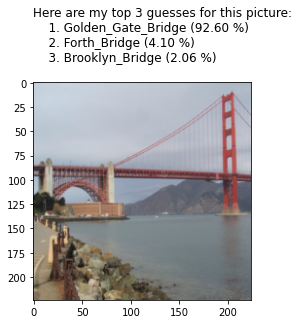

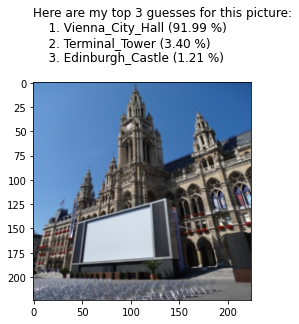

In [12]:
def suggest_locations(img_path, img_size):
    # get landmark predictions
    pred = predict_landmarks(img_path, img_size, 3)
    
    # transforms to resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
        ])
    
    # load the image
    img = Image.open(img_path)
    img = transform(img)
    
    fig = plt.figure(figsize=(5, 4))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    msg = 'Here are my top 3 guesses for this picture:\n' \
        + '    1. %s (%.2f %%)\n' % (pred[1][0], pred[0][0]*100) \
        + '    2. %s (%.2f %%)\n' % (pred[1][1], pred[0][1]*100) \
        + '    3. %s (%.2f %%)\n' % (pred[1][2], pred[0][2]*100)
    plt.title(msg, loc='left')
    
# test on a sample image
suggest_locations('./data/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', img_size)
suggest_locations('./data/landmark_images/test/19.Vienna_City_Hall/57de15850dcca86c.jpg', img_size)